## 1. __Prepare Problem__
#### __Load libraries__

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import sys
import glob
import os
import gc
##from data_prepare                  import data_prep
from tqdm.notebook                 import tqdm # progressbar
from time                          import sleep
import numpy                       as np
import matplotlib.pyplot           as plt
import seaborn                     as sns
import pandas                      as pd
import missingno                   as msno
import statsmodels.api             as sm
from cf_matrix                     import make_confusion_matrix
from collections                   import Counter
from imblearn.over_sampling        import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN,SMOTENC
from imblearn.under_sampling       import RandomUnderSampler
from imblearn.under_sampling       import AllKNN
from imblearn.under_sampling       import InstanceHardnessThreshold
from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler
from sklearn.preprocessing         import MinMaxScaler
from sklearn.model_selection       import cross_validate
from sklearn.model_selection       import KFold
from sklearn.model_selection       import RepeatedStratifiedKFold
from sklearn.model_selection       import cross_val_score
from sklearn.model_selection       import GridSearchCV
from sklearn.metrics               import classification_report
from sklearn.metrics               import confusion_matrix
from sklearn.metrics               import accuracy_score
from sklearn.metrics               import recall_score
from sklearn.metrics               import make_scorer
from sklearn.metrics               import fbeta_score
from sklearn.linear_model          import LogisticRegression 
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes           import GaussianNB
from sklearn.naive_bayes           import ComplementNB

from sklearn.svm                   import SVC
#from sklearn.pipeline              import Pipeline
from imblearn.pipeline             import Pipeline
from imblearn.pipeline             import make_pipeline
from sklearn.feature_selection     import SelectKBest
from sklearn.feature_selection     import chi2
from sklearn.feature_selection     import RFE
from sklearn.ensemble              import RandomForestClassifier
from sklearn.ensemble              import ExtraTreesClassifier
from imblearn.ensemble             import BalancedBaggingClassifier
from imblearn.ensemble             import BalancedRandomForestClassifier
from imblearn.ensemble             import EasyEnsembleClassifier
from sklearn.compose               import ColumnTransformer
from category_encoders             import *


from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.reset_option('all')
%matplotlib inline
data_path = 'data_2021-may-15/'

# separate X and Y
CM_labels = ['True Neg','False Pos','False Neg','True Pos']
CM_categories = ['Zero', 'One']


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



<a class="anchor" id="eading--2"></a>
# 2. Data Exploration and Feature Engineering

<a class="anchor" id="heading--2-1"></a>
### 2.1. Load the data

In [2]:
# load @admission file based on 1~166 csv files as the training data
df_tr     =  pd.read_csv(data_path+'@admission_all.csv', low_memory=False)
print('Dimensions of the training dataset:\n',df_tr.shape)

# load @admission file based on new data (167th csv) as the test data
df_val =  pd.read_csv(data_path+'@admission_val.csv', low_memory=False)

print('Dimensions of the test dataset:\n',df_val.shape)
print('test to all ratio :{} %\n'.format(round(100* df_val.shape[0]/(df_val.shape[0]+df_tr.shape[0]),2)))


Dimensions of the training dataset:
 (141559, 145)
Dimensions of the test dataset:
 (21714, 145)
test to all ratio :13.3 %



In [3]:
def groupby_(dataFrame, col, col_name):
    p=dataFrame.groupby(col).size()
    s=dataFrame[col].value_counts(normalize=True,sort=False).mul(100) 
    display(pd.DataFrame({'#'+col_name:s.index, '+':p.values, '%':s.values }))

<div id="heading--2-2"/>

## 2.2. __Data Cleanup Function__

The `mimic_los_cleanup` performs all of the needed data cleanup and feature engineering steps. 

In [4]:
def mimic_los_cleanup(adm_csv=data_path+'@admission_all.csv', 
                      postcode_csv='LOS/extra_info/australian_postcodes.csv', verbose=True):
    # Import CSV tables
    df =  pd.read_csv(adm_csv, low_memory=False)
    df_pc = pd.read_csv(postcode_csv)
    
    if verbose: 
        print('(1/5) Completed .csv imports')
    
    # update values of cb and met columns to indicate whether an emergency call (MET / CB) occurred or not.
    df.loc[df['met'] > 0, 'met'] = 1
    df.loc[df['cb'] > 0, 'cb'] = 1

    
    # Mark admissions where patients died in boolean column
    # drop atients who died
    df['died'] = df['died'].map(dict(Yes=1, No=0))
    #df = df[df.died != 1]
    
    # postcode (Feature Engineering)
    df['postcode'] = df['postcode'].fillna(0)
    df['postcode'] = df['postcode'].astype('int')
    
    # Merge postcode data with hospital data
    # delete postcode dataframe which not needed anymore
    df = df.merge(df_pc[['postcode','state', 'sa4','sa4name','Lat_precise','Long_precise']], on="postcode", how='left')
    del df_pc
    if verbose: 
        print('(2/5) Completed postcode (Feature Engineering).')
    
    # Admission Type (Feature Engineering)

    # handle missing data based on elective info
    fillna_list = ['etriage']
    for col in fillna_list:
        if col in df.columns:
            df[col] = df[col][df.elective==0].fillna(0) # ******  Not elective but missed  **************
            df[col] = df[col].fillna(6)                 # elective
    
    # ICD-10-AM Code (Feature Engineering)
    
    df['icd10Chapter'] = df['icd10'].astype(str).str[0]
    sub_chapte = df['icd10'].astype(str).str[1:3].astype('int')
    # replace 'neoplasms'
    df['icd10Chapter'] = np.where(df['icd10Chapter'] =='C'  , 'C/D', df['icd10Chapter'])
    df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='D') & (sub_chapte<49) , 'C/D', df['icd10Chapter'])
    # replace 'Infectious'
    df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='A') | (df['icd10'].astype(str).str[0]=='B') , 'AB', df['icd10Chapter'])
    # replace 'injury'
    df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='S') | (df['icd10'].astype(str).str[0]=='T') , 'S/T', df['icd10Chapter'])
    # replace 'ex morbility'
    df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='V') | (df['icd10'].astype(str).str[0]=='Y') , 'V-Y', df['icd10Chapter'])
    
    # Associated category names
    diag_dict = {'AB': 'Infectious', 'C/D': 'Neoplasms', 'D': 'Blood',
                 'E': 'Endocrine', 'F': 'Mental', 'G': 'Nervous', 'H': 'Eye/Ear',
                 'I': 'Circulatory', 'J': 'Respiratory', 'K': 'Digestive', 'L': 'Skin', 
                 'M': 'Muscular', 'N': 'Genitourinary', 'O': 'Pregnancy', 'P': 'Prenatal',
                 'Q': 'Congenital', 'R': 'Symptoms', 'S/T': 'Injury',
                 'U-V': 'Morbidity', 'Z': 'misc'}
    df['ICD10AM'] = df['icd10Chapter'].replace(diag_dict)
    
    if verbose: 
        print('(3/5) Completed Admission Type and ICD-10-AM Code (Feature Engineering)')
        
    # Age (Feature Engineering)
    bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 120]
    labels = [1,2,3,4,5,6,7,8,9] #['<20','20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89','+90']
    df['age_range'] = pd.cut(df.age, bins, labels = labels,include_lowest = True)
    
    # Drop useless columns
    columns_to_remove = ['sex', 'pproc','pdiagd','pprocd','ecomplaint','cunit','elective2', 'diagnosis',                                # redundante       -'pdiag' ,'nhin','statin','transin'
                         #'vascular','stroke','respiratory','renal','nsurg','genmed','cts','gensurg','ort','ent','card',                # redundante in (unitcode)
                         'sa4name', 'etriage_cat','icd10Chapter','age',                                                                 # redundante
                         'cadmitmbs','icd10',                                                                                           # codded           
                         'drg', 'wies', 'period', 'survive10', 'agerisk', 'cexpstay', 'outcome', 'arrest',                              # outcome/leakage  -'died'
                         'cicu', 'ctheatre', 'atrisk','anyarrest', 'call', 'anycall',                                                   # outcome/leakage  -hiout, 'met', 'cb',
                         'cbed','postcode',                                                                                             # location
                         'dt','cadttext','padmdtext','rdt','cadt','padt','admitdt','adt','dischargedt','ddt', 'sequencelos',            # date/time
                         'dobt', 'dodt', 'ad','dd' ,'dob', 'dod', 'eventdate','ageadmission',                                           # date/time
                         'id', 'Unnamed: 0','sequence','pvisit','visit','urno',                                                         # id                ,  
                         'phc','bicarbc','lactatec','hbc','wccc','creatininec','plateletsc','phc2','bicarbc2','lactatec2','hbc2',       # useless
                         'wccc2','creatininec2','plateletsc2',                                                                          # useless
                         'evisit','punit','plos' ,'Lat_precise','Long_precise','pcall','frail2' ,'frail3',                              # useless                   
                        ]
    new_columns = [col for col in df.columns if col not in columns_to_remove]
    data = df[new_columns]
    
    if verbose: 
        print('(4/5) Completed Age Feature Engineering and Droping useless columns')
    
    # Missing Values   
    fillna_list = ['frailty','pcomorbid','combinedscore','sadd','srsd','ser','seo','ecomplaintcode', 'sa4','state', 'pdiag','diagnosis', 'cadmitmbs','icd10']
    for col in fillna_list:
        if col in data.columns:
            data[col] = data[col].fillna(-1)

    if 'hiout' in data.columns:
        data = data[data['hiout'].notna()]
        
    # Recategorization
    binary_cols = ['frail2', 'hiout', 'edvisit','outlier']
    for col in binary_cols:
        if col in data.columns:
            if col != 'frail2':
                data[col] = data[col].map({'Yes': 1, 'No': 0})
            else:
                data[col] = data[col].map({'Frail': 1, 'Normal': 0})
    
    
    if verbose: 
        print('(5/5) Completed missing value handeling')
    


    if verbose: 
        print('Data Preprocessing complete.')
    
    print('Total Number of remained missing values --> {}'.format(data.isna().sum().sum()))
    print('Dimensions of the final dataset: {}\n'.format(df.shape))
    
    return data

In [5]:
train_ad_path   = data_path+'@admission_all.csv'
test_ad_path    = data_path+'@admission_val.csv'
post_path = 'LOS/extra_info/australian_postcodes.csv'

print('Training data:')
df_tr   = mimic_los_cleanup(adm_csv=train_ad_path,  postcode_csv=post_path, verbose=True)
print('Test data:')
df_test = mimic_los_cleanup(adm_csv=test_ad_path,   postcode_csv=post_path, verbose=True)

Training data:
(1/5) Completed .csv imports
(2/5) Completed postcode (Feature Engineering).
(3/5) Completed Admission Type and ICD-10-AM Code (Feature Engineering)
(4/5) Completed Age Feature Engineering and Droping useless columns
(5/5) Completed missing value handeling
Data Preprocessing complete.
Total Number of remained missing values --> 0
Dimensions of the final dataset: (674275, 153)

Test data:
(1/5) Completed .csv imports
(2/5) Completed postcode (Feature Engineering).
(3/5) Completed Admission Type and ICD-10-AM Code (Feature Engineering)
(4/5) Completed Age Feature Engineering and Droping useless columns
(5/5) Completed missing value handeling
Data Preprocessing complete.
Total Number of remained missing values --> 0
Dimensions of the final dataset: (93936, 153)



In [6]:
with pd.option_context('display.max_colum', None):
    display(df_tr.tail(1))
    display(df_test.tail(1))

,indig,cward,csource,cadmitclass,cpvthlth,ecomplaintcode,etriage,pcomorbid,combinedscore,c_mi,c_chf,c_pvd,c_cvd,c_dementia,c_cpd,c_ctd,c_pud,c_mld,c_dmnc,c_dmcc,c_hemi,c_renal,c_cancer,c_ld,c_metca,c_aids,pdiag,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,sadd,srsd,ser,seo,ip12m,ip24m,ed12m,ed24m,frailty,died,met,cb,hiout,charlsum,charl2,edvisit,ipany,edany,male,unitcode,statin,transin,nhin,pmet,charl3,vascular,stroke,respiratory,renal,nsurg,genmed,cts,gensurg,ort,ent,card,elective,outlier,state,sa4,ICD10AM,age_range
674274,0,EMU,HME,EMD,1,DIA,4.0,0.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M75.1,0,7.4,30,1.0,131,7.6,166,276,9.0,8.0,3.0,10.0,2,2,1,1,8.7,0,0,0,0,0,0,1,1,1,0,ESS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,VIC,206.0,Infectious,8


,indig,cward,csource,cadmitclass,cpvthlth,ecomplaintcode,etriage,pcomorbid,combinedscore,c_mi,c_chf,c_pvd,c_cvd,c_dementia,c_cpd,c_ctd,c_pud,c_mld,c_dmnc,c_dmcc,c_hemi,c_renal,c_cancer,c_ld,c_metca,c_aids,pdiag,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,sadd,srsd,ser,seo,ip12m,ip24m,ed12m,ed24m,frailty,died,met,cb,hiout,charlsum,charl2,edvisit,ipany,edany,male,unitcode,statin,transin,nhin,pmet,charl3,vascular,stroke,respiratory,renal,nsurg,genmed,cts,gensurg,ort,ent,card,elective,outlier,state,sa4,ICD10AM,age_range
93935,0,EOU,HME,EMD,1,-1,6.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,7.4,25,1.5,173,6.5,81,236,3.0,1.0,1.0,9.0,0,0,0,0,-1.0,0,0,0,0,0,0,0,0,0,1,ESS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,VIC,206.0,Circulatory,6


### 2. Imbalanced dataset

    * Check out data imbalance  
    * Oversampling

The anycall classes follows an imbalance distribution since the majority of patients have anycall=0 (99%).

In [7]:
for col, col_name in zip(['cb','met'],['cb','met']):
    groupby_(df_tr, col, col_name+'_train')
    groupby_(df_test, col, col_name+'_test')

,#cb_train,+,%
0,0,672271,99.70708
1,1,1975,0.29292


,#cb_test,+,%
0,0,93563,99.679323
1,1,301,0.320677


,#met_train,+,%
0,0,660824,98.009332
1,1,13422,1.990668


,#met_test,+,%
0,0,91190,97.151197
1,1,2674,2.848803


## Predicting Code Blue

In [8]:
# drop 'met' column
df_tr.drop(  ['met','ICD10AM','died'], axis=1, inplace=True) 
df_test.drop(['met','ICD10AM','died'], axis=1, inplace=True) 

* __Separate categorical and Numerical features__

In [9]:
# determine categorical and numerical features
numerical_ix   = df_tr.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df_tr.select_dtypes(include=['object', 'bool']).columns

# separate categorical columns into two groups (oneHot encoding and Target encoding candidates)
one_hot_cols , target_enc_cols = [], []
for col in categorical_ix:
    if len(df_tr[col].unique()) < 10:
        one_hot_cols.append(col)
    else:
        target_enc_cols.append(col)
print(one_hot_cols, target_enc_cols)



['csource', 'cadmitclass', 'state'] ['cward', 'ecomplaintcode', 'pdiag', 'unitcode']


In [10]:
X_train, y_train = df_tr.iloc  [:, df_tr.columns   != 'cb'], df_tr  ['cb']
X_test , y_test  = df_test.iloc[:, df_test.columns != 'cb'], df_test['cb']

* __Apply Target encoding on categorical columns__

In [11]:
print(X_test.shape, X_train.shape)
encoder = ColumnTransformer(transformers=[('cat',   MEstimateEncoder(randomized=True), categorical_ix )], remainder='passthrough') 
X_train_enc = encoder.fit_transform(X_train, y_train)
X_test_enc  = encoder.transform(X_test)
del df_tr, df_test
gc.collect()


(93864, 73) (674246, 73)


62

In [12]:
with pd.option_context('display.max_columns', None):
    display(X_train.tail(1))


,indig,cward,csource,cadmitclass,cpvthlth,ecomplaintcode,etriage,pcomorbid,combinedscore,c_mi,c_chf,c_pvd,c_cvd,c_dementia,c_cpd,c_ctd,c_pud,c_mld,c_dmnc,c_dmcc,c_hemi,c_renal,c_cancer,c_ld,c_metca,c_aids,pdiag,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,sadd,srsd,ser,seo,ip12m,ip24m,ed12m,ed24m,frailty,hiout,charlsum,charl2,edvisit,ipany,edany,male,unitcode,statin,transin,nhin,pmet,charl3,vascular,stroke,respiratory,renal,nsurg,genmed,cts,gensurg,ort,ent,card,elective,outlier,state,sa4,age_range
674274,0,EMU,HME,EMD,1,DIA,4.0,0.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M75.1,0,7.4,30,1.0,131,7.6,166,276,9.0,8.0,3.0,10.0,2,2,1,1,8.7,0,0,0,1,1,1,0,ESS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,VIC,206.0,8


### 2.5 Feature Selection
* __methods generating under-sampled subsets combined inside an ensemble__

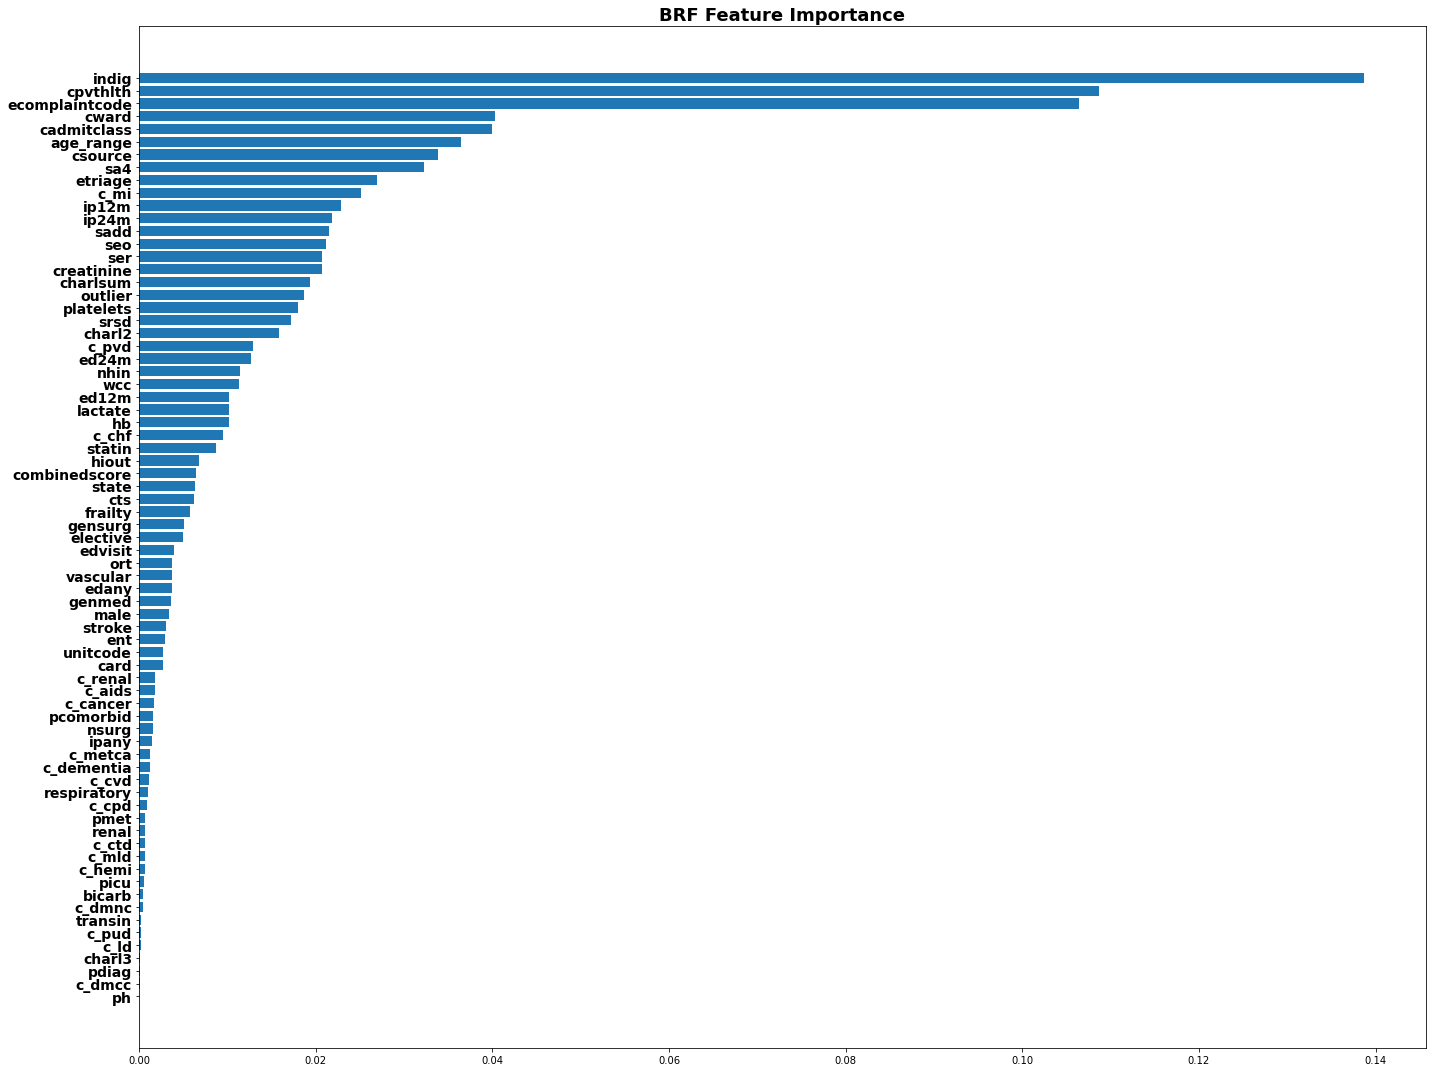

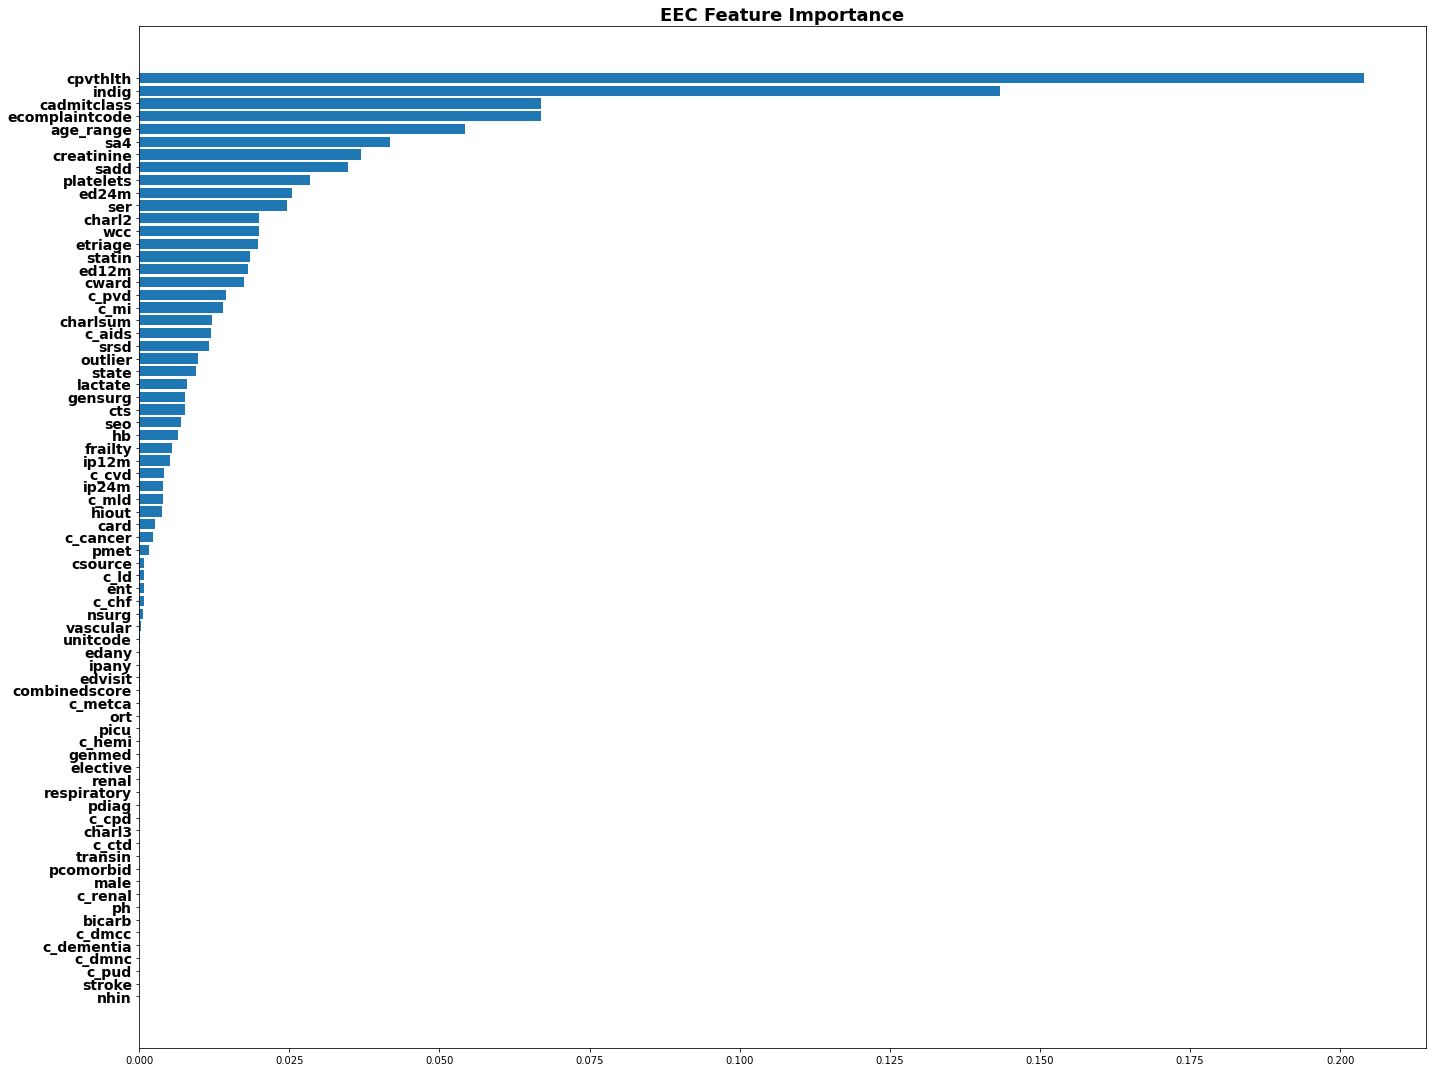

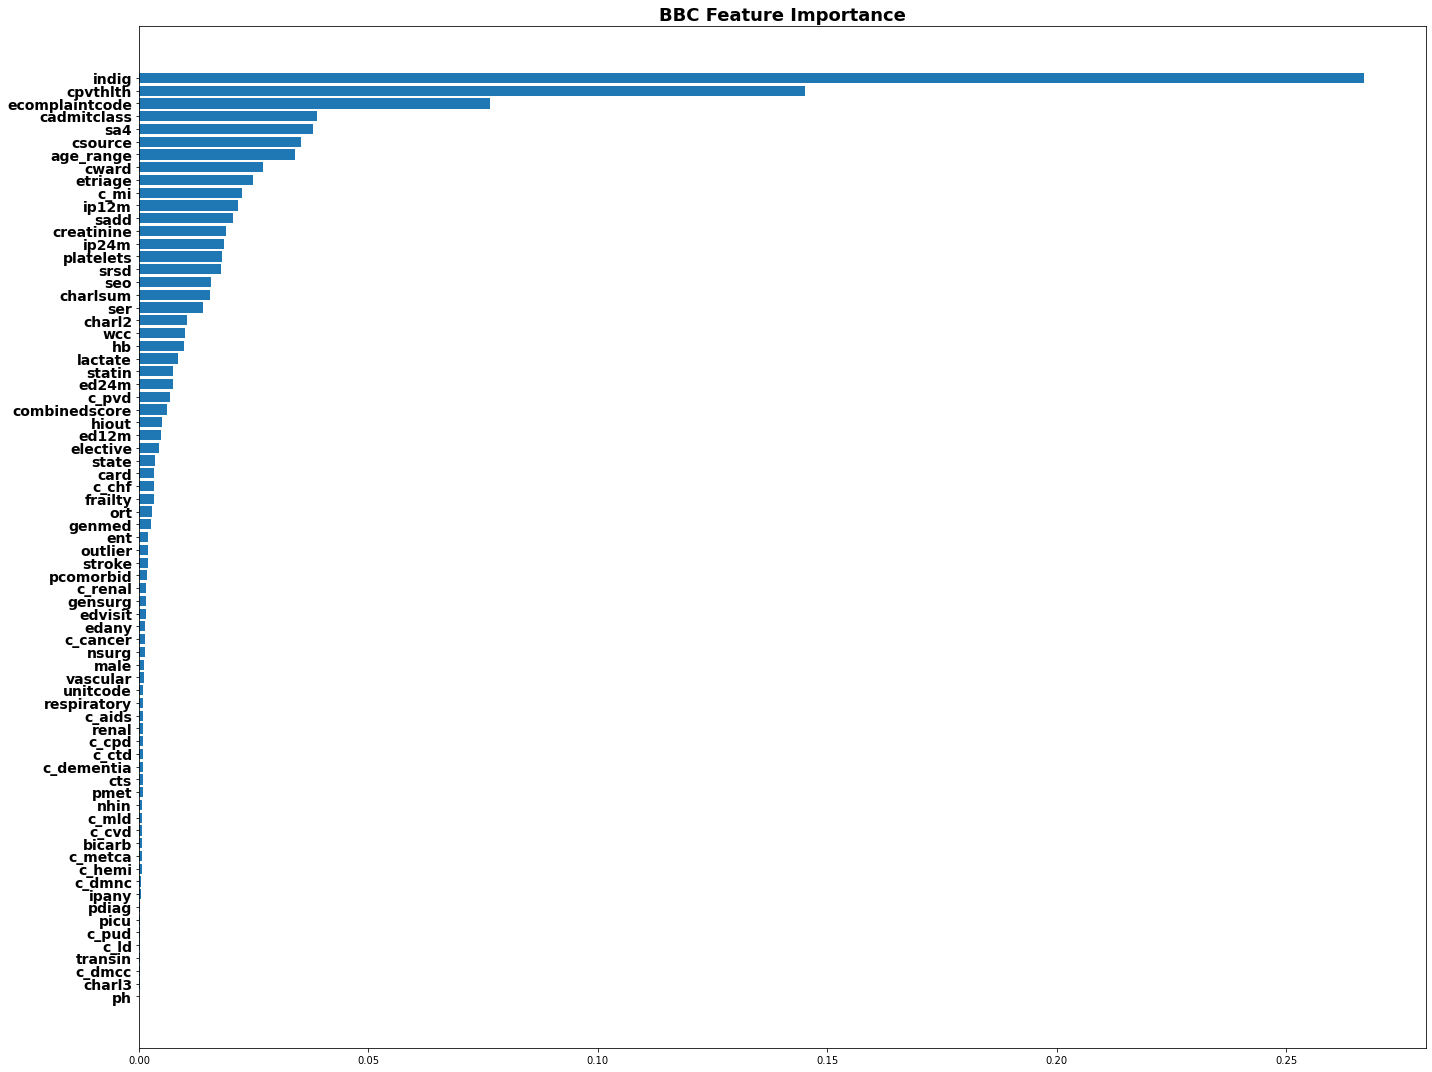

37057

In [13]:

cols = list(X_train.columns)
plt.rcParams['figure.figsize'] = (20.0, 15.0)

def plot_importance(indices, feature_importances, title):    
    sorted_idx = indices[::-1]
    feature_names = np.array(cols)[sorted_idx].tolist()
    y_ticks  = np.arange(0, len(feature_names)) 
    fig, ax = plt.subplots()
    ax.barh(y_ticks,feature_importances[sorted_idx], align='center')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names, weight = 'bold', fontsize=14)
    ax.set_title(title, weight = 'bold', fontsize=18)
    fig.tight_layout()
    #plt.savefig('Fimportance.png')
    plt.show()
    

def get_models():
    models, names = list(), list()
    
    # BRF
    models.append( BalancedRandomForestClassifier(n_estimators=100, n_jobs=-1))
    names.append('BRF')
    # EEC
    models.append( EasyEnsembleClassifier(n_estimators=100, n_jobs=-1)) 
    names.append('EEC')
    # BBC
    models.append( BalancedBaggingClassifier(n_estimators=100, n_jobs=-1))
    names.append('BBC')
    return models, names



indeces = []
# define models
models, names = get_models()
# evaluate each model
for i in range(len(models)):
    model = models[i]
    fit = model.fit(X_train_enc, y_train)
    if names[i] == 'BRF':
        importance = -model.feature_importances_
    elif names[i] == 'BBC' or 'EEC':
        importance = -(np.mean([est.steps[1][1].feature_importances_ for est in model.estimators_], axis=0))
    indices_ = np.argsort(importance)
    selected_features_names = np.array(cols)[indices_]
    indeces.append(indices_)
    plot_importance(indices_, -importance, names[i]+' Feature Importance')
gc.collect()

* __Fnding 70 most voted (important) features__

In [14]:
Num_of_imp_features = 70
most_vote_dict = {k: v for v, k in enumerate(indeces[0])}

ind_list = [indeces[1], indeces[2]]
for lst in ind_list:
    for v, k in enumerate(lst):
        most_vote_dict[k] +=v

most_vote_sorted = {k: v for k, v in sorted(most_vote_dict.items(), key=lambda item: item[1])}
MV_ind = list(most_vote_sorted.keys())
mv_df = pd.DataFrame({'70 Most important features':np.array(cols)[MV_ind[:Num_of_imp_features]]})
with pd.option_context('display.max_columns', None): 
    display(mv_df.T)

# Select important features
top_70_features = list(np.array(cols)[MV_ind[:Num_of_imp_features]])

X_Train = X_train[top_70_features]
print('\nData shape: X:{}  & y:{}'.format(X_Train.shape,y_train.shape))

# handling ram usage
del  cols, Num_of_imp_features, most_vote_sorted
gc.collect()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
70 Most important features,indig,cpvthlth,ecomplaintcode,cadmitclass,age_range,sa4,cward,etriage,sadd,creatinine,c_mi,platelets,ser,csource,ip12m,charl2,charlsum,srsd,ed24m,ip24m,seo,wcc,c_pvd,statin,ed12m,lactate,outlier,hb,state,hiout,frailty,c_chf,gensurg,combinedscore,card,cts,c_aids,elective,ent,ort,edvisit,edany,vascular,genmed,c_cancer,unitcode,nsurg,c_cvd,male,c_renal,pcomorbid,pmet,nhin,stroke,c_mld,respiratory,ipany,c_metca,renal,c_cpd,c_ctd,c_ld,c_dementia,c_hemi,picu,bicarb,pdiag,transin,c_dmnc,charl3



Data shape: X:(674246, 70)  & y:(674246,)


0

*  #### __Top Features__

In [16]:

X_train_top = X_train[top_70_features]
X_test_top = X_test[top_70_features]

categorical_ix_new = [cat for cat in categorical_ix if cat in top_70_features]
Enc = ColumnTransformer(transformers=[('cat',   MEstimateEncoder(randomized=True), categorical_ix_new )], remainder='passthrough')

## 3. Imbalanced Classification

*  ### 2.5. __Best models__ : precision_recall_curve comparison

In [17]:
def get_models():
    models, names = list(), list()
    model_1 = LogisticRegression(C=3, penalty='l2',solver='newton-cg', class_weight='balanced')
   
    # LR
    models.append(Pipeline(steps=[('prep',Enc),('t1', MinMaxScaler()),('m',model_1)]))#
    names.append('LR')   
    
    # CNB
    models.append(Pipeline(steps=[('prep',Enc),('t1', MinMaxScaler()),('m',ComplementNB()]))#
    names.append('CNB')
    
    # CNB
    models.append(Pipeline(steps=[('prep',Enc),('t1', MinMaxScaler()),('m',EasyEnsembleClassifier(n_estimators=100, n_jobs=-1))]))#
    names.append('CNB')
   
    
    return models, names

In [18]:
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import average_precision_score
# evaluate a model
def PRC_model(X_tr, y_tr, X_tst, y_tst,  model):
    # define evaluation procedure
    model.fit(X_tr, y_tr)
    probs = model.predict_proba(X_tst)[:, 1]    

    precision, recall, _ = precision_recall_curve(y_tst, probs)
    auc_ = auc(recall, precision)
    
    prediction = model.predict(X_tst)
    average_precision = average_precision_score(y_tst, prediction)

    return precision, recall, auc_, average_precision

def PRC_models(models, names, results):
    baseline_model = sum(y_test == 1) / len(y_test)
    
    plt.figure(figsize=(20, 10))
    plt.plot([0, 1], [baseline_model, baseline_model], linestyle='--', label='Baseline model')    
    
    # evaluate each model
    for i in range(len(models)):
        # evaluate the model and store results
        precision, recall, auc_, average_precision = PRC_model(X_train_top, y_train, X_test_top, y_test, models[i])
        plt.plot(recall, precision, label='AUC ({}): {:.2f}'.format(names[i], auc_))
        print('{}: precision: {}, recall: {}, auc_: {}, Average precision-recall: {}'.format(names[i],np.mean(precision),np.mean(recall), auc_, average_precision))
        
     
    # plot the results
    plt.title('Precision-Recall Curve', size=20)
    plt.xlabel('Recall', size=14)
    plt.ylabel('Precision', size=14)
    plt.legend();
    plt.show()

LR: precision: 0.06046203082175264, recall: 0.8104386045591322, auc_: 0.09483499681475123, Average precision-recall: 0.06465411571802254


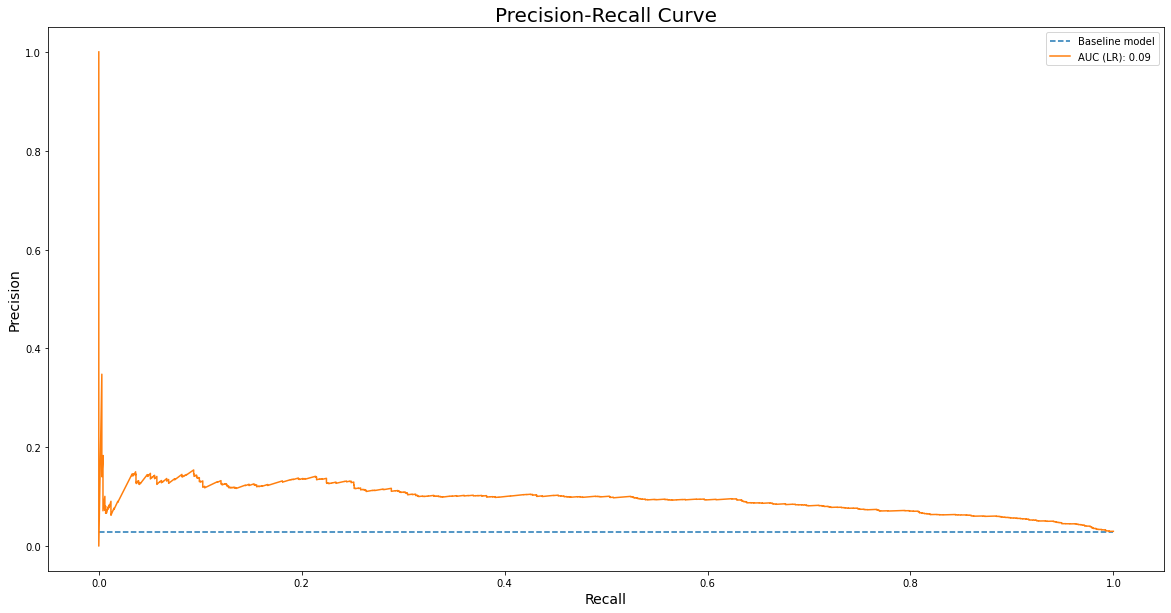

In [19]:
models, names = get_models()
results = list()
PRC_models(models, names, results)

### 2.6 __Hyperparameter Tuning__ 


In [26]:
def get_models():
    models, names, spaces= list(), list(), list()
   
    # LR
    pipeline_lr = Pipeline(steps=[('columntransformer',Enc),('t1', MinMaxScaler()), ('model', LogisticRegression(class_weight='balanced'))])
    # define grid
    grid = dict()
    grid['model__solver'] = ['newton-cg','liblinear']
    grid['model__penalty'] = ['l2']
    grid['model__C'] = [1,3,5]
    models.append(pipeline_lr)#
    names.append('LR') 
    spaces.append(grid)
    
    # EEC
    pipeline_eec = Pipeline(steps=[('columntransformer',Enc), ('model', EasyEnsembleClassifier(n_jobs=-1))])
    # define grid
    grid = dict()
    grid['model__n_estimators'] = [100,200]

    models.append(pipeline_eec)#
    names.append('EEC') 
    spaces.append(grid)
    
    
    return models, names, spaces

In [25]:
# evaluate a model
def gc_model(X, y, model, space):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(recall_score)#sensitivity_score)
    #metric = make_scorer(fbeta_score, beta=2)
    # evaluate model
    search = GridSearchCV(estimator=model, param_grid=space, n_jobs=-1, cv=cv, scoring=metric, error_score=0)
    search_result = search.fit(X, y)
    print('Training set score: ' + str(search.score(X, y)))
    print('Test set score: ' + str(search.score(X_test_top, y_test)))
    return search_result

def gc_models(models, names, results, spaces):
        
    # evaluate each model
    for i in range(len(models)):
        # evaluate the model and store results
        search_result = gc_model(X_train_top, y_train, models[i], spaces[i])
        #results.append(scores)
        # summarize and store
        print("Best of %s: %f using %s \n" % (names[i], search_result.best_score_, search_result.best_params_))


In [27]:
models, names, spaces = get_models()
results = list()
gc_models(models, names, results, spaces)

Training set score: 0.796230070034272
Test set score: 0.7213911742707554
Best of LR: 0.782521 using {'model__C': 5, 'model__penalty': 'l2', 'model__solver': 'liblinear'} 



KeyboardInterrupt: 

* Best model performance

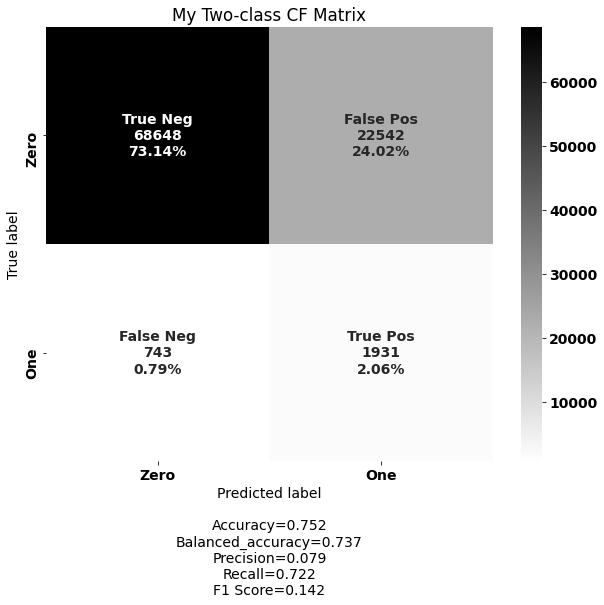

In [31]:
from sklearn.preprocessing import RobustScaler
model = LogisticRegression(C= 1, penalty= 'l2',solver='newton-cg',class_weight='balanced')
# Scaling
sc = MinMaxScaler() 

X_train_enc    = Enc.fit_transform(X_train_top, y_train)
X_train_enc    = sc.fit_transform(X_train_enc)

X_test_enc    = Enc.transform(X_test_top)
X_test_enc    = sc.transform(X_test_enc)

model.fit(X_train_enc, y_train)

predictions = model.predict(X_test_enc)
cf_matrix = confusion_matrix(y_test, predictions)
make_confusion_matrix(cf_matrix, group_names=CM_labels, categories=CM_categories, cmap='binary', title='My Two-class CF Matrix')

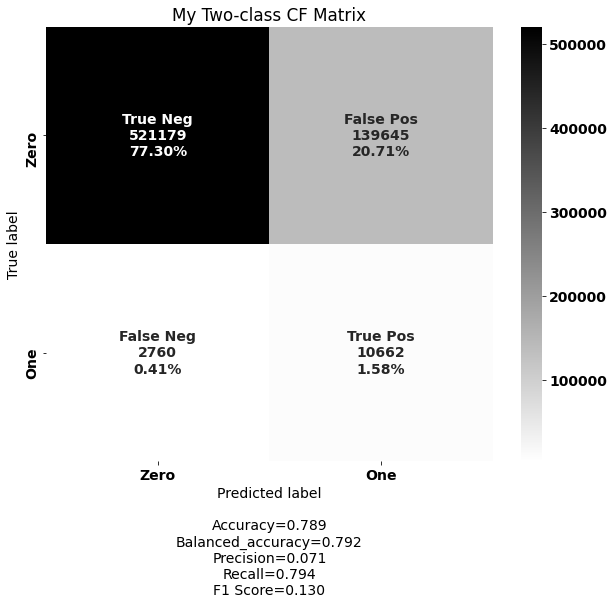

In [35]:
predictions_ = model.predict(X_train_enc)
cf_matrix = confusion_matrix(y_train, predictions_)
make_confusion_matrix(cf_matrix, group_names=CM_labels, categories=CM_categories, cmap='binary', title='My Two-class CF Matrix')

#### __Error Analysis__


In [34]:
ind = 0
for row_index, (input, prediction, label) in enumerate(zip (X_test_enc, predictions, y_test)):
  if prediction != label:
    ind +=1
    print('Row', row_index, 'has been classified as ', prediction, 'and should be ', label)
print(ind)

Row 60 has been classified as  1 and should be  0
Row 61 has been classified as  1 and should be  0
Row 62 has been classified as  1 and should be  0
Row 63 has been classified as  1 and should be  0
Row 64 has been classified as  1 and should be  0
Row 65 has been classified as  1 and should be  0
Row 66 has been classified as  1 and should be  0
Row 208 has been classified as  1 and should be  0
Row 209 has been classified as  1 and should be  0
Row 210 has been classified as  1 and should be  0
Row 211 has been classified as  1 and should be  0
Row 242 has been classified as  1 and should be  0
Row 243 has been classified as  1 and should be  0
Row 251 has been classified as  1 and should be  0
Row 252 has been classified as  1 and should be  0
Row 253 has been classified as  1 and should be  0
Row 254 has been classified as  1 and should be  0
Row 255 has been classified as  1 and should be  0
Row 256 has been classified as  1 and should be  0
Row 257 has been classified as  1 and 